In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!apt-get update
!apt-get install -y openjdk-11-jdk-headless
!pip install pyspark

from pyspark.sql import SparkSession
from scipy.io import arff
import pandas as pd
from pyspark.sql.functions import when, col


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 261 kB in 2s (161 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pa

In [3]:
try:
    sc.stop()
except:
    pass

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Heart Disease Classification") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.default.parallelism", "4") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print("SparkSession Initialized:", spark)

SparkSession Initialized: <pyspark.sql.session.SparkSession object at 0x7f252ccd6380>


In order to start our machine learning task with pyspark, first we need to read the dataset file, decode and transfer data to spark DataFrame

In [4]:

# Read ARFF file
data, meta = arff.loadarff('/content/drive/MyDrive/DDAM/BNG_heart-statlog.arff')

# transfer data to pandas DataFrame
df = pd.DataFrame(data)

df['class'] = df['class'].str.decode('utf-8')

# transfer pandas DataFrame ro spark DataFrame

spark_df = spark.createDataFrame(df)

#1.Data Understanding

In this heart disease dataset, numerous medical indicators are included, and the detailed explanations for these labeled variables have already been covered in the report. As such, we will not elaborate on them here.

 Additionally, since this is a synthetic dataset, most of the data has already been cleaned, including standardization and feature scaling. Therefore, the only remaining preprocessing step involves handling the target variable, which is encoded as a string (present and absent).

In [ ]:
spark_df.show(20)

+---------+---+--------+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+--------+-----+-----------------------+----+-------+
|      age|sex|   chest|resting_blood_pressure|serum_cholestoral|fasting_blood_sugar|resting_electrocardiographic_results|maximum_heart_rate_achieved|exercise_induced_angina| oldpeak|slope|number_of_major_vessels|thal|  class|
+---------+---+--------+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+--------+-----+-----------------------+----+-------+
|53.494725|1.0|1.150395|            117.978412|        242.00937|                0.0|                                 0.0|                 133.361344|                    0.0|3.089391|  2.0|                    1.0| 3.0|present|
|37.320375|0.0|1.887693|             118.45567|       218.156844|                1.0|       

In [ ]:
spark_df.printSchema()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- chest: double (nullable = true)
 |-- resting_blood_pressure: double (nullable = true)
 |-- serum_cholestoral: double (nullable = true)
 |-- fasting_blood_sugar: double (nullable = true)
 |-- resting_electrocardiographic_results: double (nullable = true)
 |-- maximum_heart_rate_achieved: double (nullable = true)
 |-- exercise_induced_angina: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- number_of_major_vessels: double (nullable = true)
 |-- thal: double (nullable = true)
 |-- class: string (nullable = true)



There are neither duplicates nor missing values in our dataset.

In [ ]:
duplicate_rows = spark_df.groupBy(spark_df.columns).count().filter("count > 1")
duplicate_rows.show()


+---+---+-----+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+-------+-----+-----------------------+----+-----+-----+
|age|sex|chest|resting_blood_pressure|serum_cholestoral|fasting_blood_sugar|resting_electrocardiographic_results|maximum_heart_rate_achieved|exercise_induced_angina|oldpeak|slope|number_of_major_vessels|thal|class|count|
+---+---+-----+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+-------+-----+-----------------------+----+-----+-----+
+---+---+-----+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+-------+-----+-----------------------+----+-----+-----+



In [ ]:
missing_rows = spark_df.filter(
    " OR ".join([f"{c} IS NULL" for c in spark_df.columns])
)
print(f"Number of rows with missing values: {missing_rows.count()}")


Number of rows with missing values: 0


#2.Data Preprocessing


##2.1Feature Engineering

In this data preprocessing phase, we first convert our target variable into a binary variable (1 and 0) to facilitate the modeling process.

In [5]:
from pyspark.sql.functions import when, col

from pyspark.sql.functions import round as pyspark_round, col

# Round and convert 'age' and 'chest' columns to integers in PySpark
spark_df = spark_df.withColumn("age", pyspark_round(col("age")).cast("int"))
spark_df = spark_df.withColumn("chest", pyspark_round(col("chest")).cast("int"))
spark_df = spark_df.withColumn("sex", pyspark_round(col("sex")).cast("int"))
spark_df = spark_df.withColumn("fasting_blood_sugar", pyspark_round(col("fasting_blood_sugar")).cast("int"))
spark_df = spark_df.withColumn("resting_electrocardiographic_results", pyspark_round(col("resting_electrocardiographic_results")).cast("int"))
spark_df = spark_df.withColumn("exercise_induced_angina", pyspark_round(col("exercise_induced_angina")).cast("int"))
spark_df = spark_df.withColumn("slope", pyspark_round(col("slope")).cast("int"))
spark_df = spark_df.withColumn("number_of_major_vessels", pyspark_round(col("number_of_major_vessels")).cast("int"))
spark_df = spark_df.withColumn("thal", pyspark_round(col("thal")).cast("int"))



# replace present/absent with 1 and 0
spark_df = spark_df.withColumn(
    "class",
    when(col("class") == "present", 1)
    .when(col("class") == "absent", 0)
    .otherwise(None)
)


spark_df.show(20)


+---+---+-----+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+--------+-----+-----------------------+----+-----+
|age|sex|chest|resting_blood_pressure|serum_cholestoral|fasting_blood_sugar|resting_electrocardiographic_results|maximum_heart_rate_achieved|exercise_induced_angina| oldpeak|slope|number_of_major_vessels|thal|class|
+---+---+-----+----------------------+-----------------+-------------------+------------------------------------+---------------------------+-----------------------+--------+-----+-----------------------+----+-----+
| 53|  1|    1|            117.978412|        242.00937|                  0|                                   0|                 133.361344|                      0|3.089391|    2|                      1|   3|    1|
| 37|  0|    2|             118.45567|       218.156844|                  1|                                   2|                 148.45

Next, we combine multiple features into a single feature vector, transforming the data from a multi-column format into a format that can be accepted by the model.

##2.2Data Splitting

After performing feature engineering, we proceed to split the dataset into training and testing sets in preparation for subsequent model training and evaluation.

#3.Exploratory Data Analysis

Please refer to the notebook DDAM_Group9_Part1.

#4.Supervised Learning

In performing the machine learning task on this dataset using supervised learning models, we chose Random Forest and Logistic Regression as our two models.

##4.1Raindom Forest

In [6]:
from pyspark.ml.feature import OneHotEncoder, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


processed_df = spark_df.withColumnRenamed("class", "label")

In [7]:

train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)



*   Metrics Definition



In [12]:
def print_metrics(predictions, model_name):
    """
    Calculate and print the model evaluation metrics.

    Parameters:
        predictions: DataFrame containing the prediction results
        model_name: The name of the model, for display purposes
    """
    # Calculate weighted recall
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )

    # Calculate F1 score - using "f1" instead of "weightedF1"
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"  # This is the key modification
    )

    recall = evaluator_recall.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def plot_confusion_matrix(predictions, model_name):
    """
    Plot confusion matrix heatmap using matplotlib.
    """
    # Convert predictions to Pandas DataFrame
    conf_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)
    conf_matrix_pd = conf_matrix.toPandas()

    # Set confusion matrix data
    matrix_values = conf_matrix_pd.iloc[:, 1:].values

    # Create the figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix_values,
                annot=True,
                fmt='g',
                cmap='Blues',
                xticklabels=range(len(matrix_values)),
                yticklabels=range(len(matrix_values)))

    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [34]:
unchanged_columns = ["sex", "fasting_blood_sugar", "resting_electrocardiographic_results",
                     "exercise_induced_angina", "slope", "number_of_major_vessels", "thal"]

# Create feature engineering components for the Logistic Regression model
lr_encoder_chest = OneHotEncoder(
    inputCol="chest",
    outputCol="chest_onehot_lr",
    dropLast=False
)

lr_scaler_age = StandardScaler(
    inputCol="age",
    outputCol="scaled_age_lr",
    withStd=True,
    withMean=True
)

lr_scaler_rbp = StandardScaler(
    inputCol="resting_blood_pressure",
    outputCol="scaled_rbp_lr",
    withStd=True,
    withMean=True
)

lr_scaler_schol = StandardScaler(
    inputCol="serum_cholestoral",
    outputCol="scaled_schol_lr",
    withStd=True,
    withMean=True
)

lr_scaler_max_hr = StandardScaler(
    inputCol="maximum_heart_rate_achieved",
    outputCol="scaled_max_hr_lr",
    withStd=True,
    withMean=True
)

lr_scaler_oldpeak = StandardScaler(
    inputCol="oldpeak",
    outputCol="scaled_oldpeak_lr",
    withStd=True,
    withMean=True
)

# Create feature assemblers for both models
rf_assembler = VectorAssembler(
    inputCols=["age", "chest", "resting_blood_pressure", "serum_cholestoral",
               "maximum_heart_rate_achieved", "oldpeak"] + unchanged_columns,
    outputCol="features_rf"
)

lr_assembler = VectorAssembler(
    inputCols=["scaled_age_lr", "chest_onehot_lr", "scaled_rbp_lr", "scaled_schol_lr",
               "scaled_max_hr_lr", "scaled_oldpeak_lr"] + unchanged_columns,
    outputCol="features_lr"
)

# Verify feature engineering components
print("Feature engineering configuration completed. Features used by Random Forest:")
print(rf_assembler.getInputCols())
print("\nFeatures used by Logistic Regression (processed):")
print(lr_assembler.getInputCols())


Feature engineering configuration completed. Features used by Random Forest:
['age', 'chest', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'oldpeak', 'sex', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']

Features used by Logistic Regression (processed):
['scaled_age_lr', 'chest_onehot_lr', 'scaled_rbp_lr', 'scaled_schol_lr', 'scaled_max_hr_lr', 'scaled_oldpeak_lr', 'sex', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'exercise_induced_angina', 'slope', 'number_of_major_vessels', 'thal']




*   Cross-validation Methods



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# Create a Random Forest pipeline
rf_pipeline = Pipeline(stages=[
    rf_assembler,
    RandomForestClassifier(labelCol="label",
                           featuresCol="features_rf",
                           seed=42)
])

# Get the Random Forest model from the pipeline
rf_model = rf_pipeline.fit(train_df).stages[-1]

# Define the parameter grid
# Select a smaller range of parameters to balance training time and model performance
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [10, 20]) \
    .addGrid(rf_model.maxDepth, [5, 7]) \
    .build()

# Create an evaluator - using weightedRecall as the main optimization metric
evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

# Configure cross-validation
rf_cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator_rf,
    numFolds=3,
    seed=42,
    parallelism=2  # Enable parallel training for efficiency
)

print("\nTraining the Random Forest model...")
rf_cvModel = rf_cv.fit(train_df)

# Retrieve and display the best parameters
best_rf_model = rf_cvModel.bestModel.stages[-1]
print("\nBest Random Forest Parameters:")
print(f"Number of Trees (numTrees): {best_rf_model.getOrDefault(best_rf_model.numTrees)}")
print(f"Tree Depth (maxDepth): {best_rf_model.getOrDefault(best_rf_model.maxDepth)}")

# print(f"Number of Trees (numTrees): {best_rf_model.getNumTrees()}")
# print(f"Tree Depth (maxDepth): {best_rf_model.getMaxDepth()}")

# Make predictions and evaluate on the test set
print("\nEvaluating the Random Forest model on the test set...")
rf_predictions = rf_cvModel.transform(test_df)

# Evaluate model performance
print_metrics(rf_predictions, "Random Forest")
plot_confusion_matrix(rf_predictions, "Random Forest")

# Analyze feature importance
feature_importance = pd.DataFrame(
    best_rf_model.featureImportances.toArray(),
    index=rf_assembler.getInputCols(),
    columns=['importance']
).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking (Top 5 Most Important Features):")
print(feature_importance.head())


##4.2Logic Regression

The target variable in our dataset is binary and logistic regression is one of the most natural and efficient models for supervised learning in binary classification tasks. Therefore, we first applied logistic regression to model the relationship between the features and the target variable.






### 4.2.1Feature Enginering



We needed to perform feature scaling on some variables since logistic regression is based on gradient optimization, it is sensitive to the
range of features.

In [21]:
from pyspark.ml.classification import LogisticRegression

# Create Logistic Regression complete pipeline
lr_pipeline = Pipeline(stages=[
    # Feature engineering steps
    lr_encoder_chest,        # One-hot encoding for chest variable
    lr_scaler_age,           # Standardize age
    lr_scaler_rbp,           # Standardize blood pressure
    lr_scaler_schol,         # Standardize cholesterol
    lr_scaler_max_hr,        # Standardize maximum heart rate
    lr_scaler_oldpeak,       # Standardize ST depression
    lr_assembler,            # Assemble all features
    LogisticRegression(labelCol="label",
                       featuresCol="features_lr",
                       family="binomial")  # Specify as a binary classification problem
])

# Define evaluation metrics function
def print_metrics(predictions, model_name):
    """
    Calculate and print model evaluation metrics
    """
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"  # Corrected evaluation metric name
    )

    recall = evaluator_recall.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


lr_assembler = VectorAssembler(
    inputCols=["scaled_age_lr",
               "chest_onehot_lr",  # Note: This is the one-hot encoded feature
               "scaled_rbp_lr",
               "scaled_schol_lr",
               "scaled_max_hr_lr",
               "scaled_oldpeak_lr"] + unchanged_columns,
    outputCol="features_lr"
)


In [22]:

lr_model = lr_pipeline.getStages()[-1]

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_model.regParam, [0.01, 0.1]) \
    .addGrid(lr_model.elasticNetParam, [0.0, 0.5]) \
    .build()


evaluator_lr = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)


lr_cv = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator_lr,
    numFolds=3,
    seed=42
)

###4.2.2 Model Training, Parameters Tunning and Model Performance


Starting Logistic Regression training...
Parameter grid search space (2*2=4 combinations):
RegParam: 0.01, ElasticNetParam: 0.0
RegParam: 0.01, ElasticNetParam: 0.5
RegParam: 0.1, ElasticNetParam: 0.0
RegParam: 0.1, ElasticNetParam: 0.5

Best Logistic Regression Parameters:
RegParam: 0.01
ElasticNetParam: 0.0

Test Set Metrics:
Recall: 0.8775
F1 Score: 0.8773

Confusion Matrix:


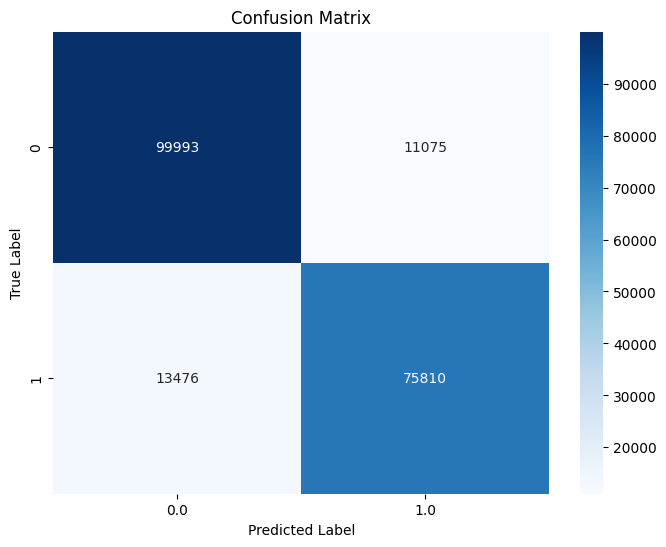

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define feature columns
feature_columns = ["age", "sex", "chest", "resting_blood_pressure",
                  "serum_cholestoral", "fasting_blood_sugar",
                  "resting_electrocardiographic_results",
                  "maximum_heart_rate_achieved", "exercise_induced_angina",
                  "oldpeak", "slope", "number_of_major_vessels", "thal"]

# Feature preprocessing
# 1. Feature vector assembly
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="assembled_features"
)

# 2. Feature standardization
scaler = StandardScaler(
    inputCol="assembled_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# 3. Define logistic regression model
lr_model = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=10
)

# 4. Define Pipeline
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_model])

# 5. Define parameter grid
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_model.regParam, [0.01, 0.1]) \
    .addGrid(lr_model.elasticNetParam, [0.0, 0.5]) \
    .build()

# 6. Define evaluator
evaluator_lr = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# 7. Configure cross validation
lr_cv = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator_lr,
    numFolds=3,
    seed=42
)

# 8. Prepare dataset
processed_df = spark_df.withColumnRenamed("class", "label")
train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)

# 9. Train model
print("\nStarting Logistic Regression training...")
print("Parameter grid search space (2*2=4 combinations):")
for params in lr_paramGrid:
    print(f"RegParam: {params[lr_model.regParam]}, " +
          f"ElasticNetParam: {params[lr_model.elasticNetParam]}")

lr_cvModel = lr_cv.fit(train_df)

# 10. Get best parameters
best_lr_model = lr_cvModel.bestModel.stages[-1]
print("\nBest Logistic Regression Parameters:")
print(f"RegParam: {best_lr_model.getRegParam()}")
print(f"ElasticNetParam: {best_lr_model.getElasticNetParam()}")

# 11. Model evaluation
lr_predictions = lr_cvModel.transform(test_df)

# Function to calculate and print multiple metrics
def print_metrics(predictions):
    # Create evaluators for different metrics
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall"
    )
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )

    # Calculate metrics
    recall = evaluator_recall.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print("\nTest Set Metrics:")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

print_metrics(lr_predictions)

# 12. Plot confusion matrix
def plot_confusion_matrix(predictions):
    # Convert predictions to pandas for visualization
    conf_matrix = predictions.groupBy("label", "prediction").count().toPandas()

    # Pivot the data to create confusion matrix
    conf_matrix_pivot = conf_matrix.pivot(index='label',
                                        columns='prediction',
                                        values='count').fillna(0)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_pivot,
                annot=True,
                fmt='g',
                cmap='Blues',
                cbar=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\nConfusion Matrix:")
plot_confusion_matrix(lr_predictions)

##4.3Conclusion

Both supervised learning algorithms performed quite well. However, the Random Forest model slightly outperformed Logistic Regression, with a recall score of 0.8849 compared to 0.8775 for Logistic Regression.

#5.Unsupervised Learning -- K-means Clustering


In [25]:
spark_df_ul = spark_df.select("*")
#Combine all feature columns into a single feature vector
feature_columns_ul = [col for col in spark_df_ul.columns if col != 'class']
assembler_ul = VectorAssembler(inputCols=feature_columns_ul, outputCol="features_ul")
df_features_ul = assembler_ul.transform(spark_df_ul)

In [26]:
train_df_ul, test_df_ul = df_features_ul.randomSplit([0.8, 0.2], seed=1234)


We first plotted the Elbow Method graph to determine the optimal number of clusters. Based on the Elbow Method, we initially identified that k=3 and k=4 were potential optimal cluster numbers.

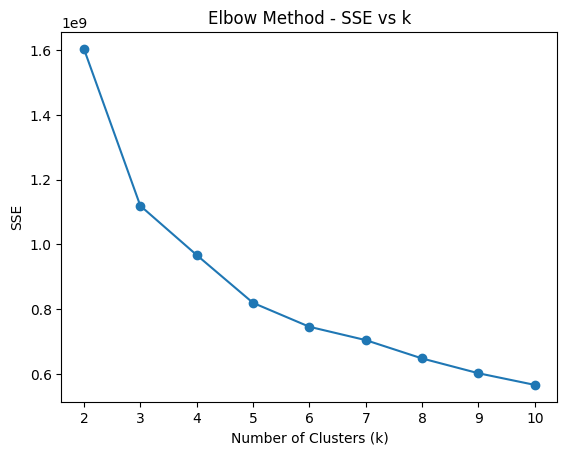

In [29]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


k_values = range(2, 11)
sse_values = []

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features_ul")
    model = kmeans.fit(train_df_ul)
    sse_values.append(model.summary.trainingCost)


plt.plot(k_values, sse_values, marker='o')
plt.title('Elbow Method - SSE vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.show()


Next, we calculated the silhouette score and used it to identify the best parameter combination. Based on this score, we trained the final model using the optimal parameters.


In [32]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F

# Create an empty list to store results
results = []

# Iterate over different parameter combinations
for k in [3, 4]:  # Test for k=3 and k=4
    for init_mode in ['random', 'k-means||']:  # Test for two initialization methods
        for max_iter in [20, 30, 40]:  # Test for different maximum iterations
            # Configure the KMeans model
            kmeans = KMeans()\
                .setK(k)\
                .setSeed(1)\
                .setInitMode(init_mode)\
                .setMaxIter(max_iter)\
                .setFeaturesCol("features_ul")

            # Train the model on the training data
            model = kmeans.fit(train_df_ul)

            # Make predictions on the training data
            predictions = model.transform(train_df_ul)

            # Calculate SSE (training cost)
            sse = model.summary.trainingCost

            # Configure the evaluator to compute silhouette score
            evaluator = ClusteringEvaluator(
                featuresCol="features_ul",
                metricName="silhouette",
                distanceMeasure="squaredEuclidean"
            )

            # Calculate silhouette score
            silhouette_score = evaluator.evaluate(predictions)

            # Add the results to the list
            results.append({
                "k": k,
                "initMode": init_mode,
                "maxIter": max_iter,
                "SSE": sse,
                "SilhouetteScore": silhouette_score
            })

# Convert results to a Spark DataFrame
results_spark_df = spark.createDataFrame(results)

# Display the results
print("Clustering model parameter evaluation results:")
results_spark_df.orderBy("SilhouetteScore", ascending=False).show()

# Find the best parameter combination (based on silhouette score)
best_params = results_spark_df.orderBy("SilhouetteScore", ascending=False).first()

print("\nBest parameter combination:")
print(f"K value: {best_params['k']}")
print(f"Initialization method: {best_params['initMode']}")
print(f"Maximum iterations: {best_params['maxIter']}")
print(f"Silhouette score: {best_params['SilhouetteScore']:.4f}")
print(f"SSE: {best_params['SSE']:.2f}")

# Train the final model using the best parameters
final_kmeans = KMeans()\
    .setK(best_params['k'])\
    .setSeed(1)\
    .setInitMode(best_params['initMode'])\
    .setMaxIter(best_params['maxIter'])\
    .setFeaturesCol("features_ul")

final_model = final_kmeans.fit(train_df_ul)

# Make predictions on the test data
final_predictions = final_model.transform(test_df_ul)

# Analyze the size of each cluster
print("\nSample size distribution of each cluster:")
final_predictions.groupBy("prediction")\
    .agg(F.count("*").alias("count"))\
    .orderBy("prediction")\
    .show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:


kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("features_ul")


model = kmeans.fit(train_df_ul)

predictions = model.transform(test_df_ul)


predictions.select("features_ul", "prediction").show()


+--------------------+----------+
|         features_ul|prediction|
+--------------------+----------+
|[27.809395,1.0,1....|         0|
|[28.772778,1.0,4....|         0|
|[30.066129,1.0,1....|         2|
|(13,[0,2,3,4,7,10...|         1|
|[30.191471,0.0,3....|         0|
|[30.232364,0.0,3....|         1|
|[30.331581,1.0,3....|         0|
|[30.513774,1.0,3....|         2|
|[30.683525,1.0,4....|         1|
|[30.779231,0.0,0....|         1|
|[30.913074,1.0,3....|         0|
|[31.010993,1.0,1....|         0|
|[31.019484,1.0,3....|         0|
|[31.033035,1.0,4....|         0|
|[31.086086,1.0,4....|         1|
|[31.14137,0.0,4.0...|         0|
|[31.243141,1.0,3....|         1|
|[31.251251,1.0,4....|         1|
|[31.369771,1.0,3....|         0|
|[31.550016,1.0,0....|         1|
+--------------------+----------+
only showing top 20 rows

